# EDA variable binaria

### Importamos las librerias necesarias y definimos las variables globales

In [ ]:
# Importamos las librerias
import numpy  as np  
import pandas as pd

import matplotlib.pyplot as plt 
%matplotlib inline

import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error 

In [ ]:
seed = 0

### Carga y preprocesado de datos

In [ ]:
# Cargamos la base de datos de entrenamiento
url = 'https://datos.uemc.es/owncloud/s/mSue0Hq5KihC3Vc/download?path=%2F&files=DATASET14.csv'
df = pd.read_csv(url, sep=',')

df.head()

,address,year,day,length,weight,count,looped,neighbors,income,label
0,111K8kZAEnJg245r2cM6y9zgJGHZtJPy6,2017,11,18,0.008333,1,0,2,100050000,princetonCerber
1,1123pJv8jzeFQaCV4w644pzQJzVWay2zcA,2016,132,44,0.000244,1,0,1,100000000,princetonLocky
2,112536im7hy6wtKbpH1qYDWtTyMRAcA2p7,2016,246,0,1.000000,1,0,2,200000000,princetonCerber
3,1129TSjKtx65E35GiUo4AYVeyo48twbrGX,2016,238,144,0.072848,456,0,1,200000000,princetonLocky
4,112AmFATxzhuSpvtz1hfpa3Zrw3BG276pc,2016,96,144,0.084614,2821,0,1,50000000,princetonLocky


In [ ]:
# Mostramos informacion basica de la estructura de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362524 entries, 0 to 2362523
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   address    object 
 1   year       int64  
 2   day        int64  
 3   length     int64  
 4   weight     float64
 5   count      int64  
 6   looped     int64  
 7   neighbors  int64  
 8   income     int64  
 9   label      object 
dtypes: float64(1), int64(7), object(2)
memory usage: 180.2+ MB


Los datos están representados mediante un dataframe de pandas que consta de 2362524 filas con ejemplos de transacciones y 10 columnas que representan las variables asociadas a cada ejemplo.  

Todas las variables que incluye el dataset son de tipo numérico, excepto la dirección y la etiqueta. Esta última es la característica que queremos predecir por lo que no presenta ningún problema el hecho de que sea una variable categórica. Sin embargo, puesto que nuestra intención es predecir si una transacción está afectada por ransomware o no, modificaremos está etiqueta a tipo binario. En cuanto al address sí que nos supone un problema su tipo de dato, y es que los algoritmos que aplicaremos solo permiten atributos de tipo numérico.  

Para solventar esto se nos abren dos alternativas, utilizar un LabelEnconder() o un OneShotEncoder de la biblioteca sklearn. El primero de estos métodos atribuirá a cada objeto distinto dentro de esta columna un número entre 0 y n-1, siendo n el número todal de valores distintos que puede tomar este campo. El problema de este LabelEncoder() es que, sin quererlo, estamos estableciendo un orden a un campo que no presenta ningún orden natural y esto puede inducir a error a los algoritmos. Descartado este método, pensamos en utilizar el OneShotEncoder(), sin embargo, este genera una cantidad tal de datos que no podemos alojarla en memoria. Por tanto, no tenemos más remedio que descartar está variable.

In [ ]:
def secuestro(x):

    if x== 'white':
        valor = 0
    else:
        valor = 1

    return valor

In [ ]:
# Creamos una columna de etiqueta binaria en los datos de entrenamiento
df['clase']=df['label'].apply(secuestro)

# Eliminamos la columna label y address
df = df.drop(['address', 'label'], axis=1)

df.head()

,year,day,length,weight,count,looped,neighbors,income,clase
0,2017,11,18,0.008333,1,0,2,100050000,1
1,2016,132,44,0.000244,1,0,1,100000000,1
2,2016,246,0,1.000000,1,0,2,200000000,1
3,2016,238,144,0.072848,456,0,1,200000000,1
4,2016,96,144,0.084614,2821,0,1,50000000,1


### Análisis exploratorio

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,2362524.0,2.014477e+03,2.258155e+00,2011.0,2.013000e+03,2.014000e+03,2.016000e+03,2.018000e+03
day,2362524.0,1.814669e+02,1.040240e+02,1.0,9.200000e+01,1.810000e+02,2.710000e+02,3.650000e+02
length,2362524.0,4.498321e+01,5.896861e+01,0.0,2.000000e+00,8.000000e+00,1.080000e+02,1.440000e+02
weight,2362524.0,5.469048e-01,3.857976e+00,0.0,2.168950e-02,2.500000e-01,8.846231e-01,1.943749e+03
count,2362524.0,7.215122e+02,1.690167e+03,1.0,1.000000e+00,1.000000e+00,5.600000e+01,1.449600e+04
looped,2362524.0,2.383994e+02,9.667588e+02,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.449600e+04
neighbors,2362524.0,2.217551e+00,1.899680e+01,1.0,1.000000e+00,2.000000e+00,2.000000e+00,1.292000e+04
income,2362524.0,4.473251e+09,1.639251e+11,30000000.0,7.431139e+07,2.000000e+08,9.938792e+08,4.982447e+13
clase,2362524.0,1.419880e-02,1.183098e-01,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


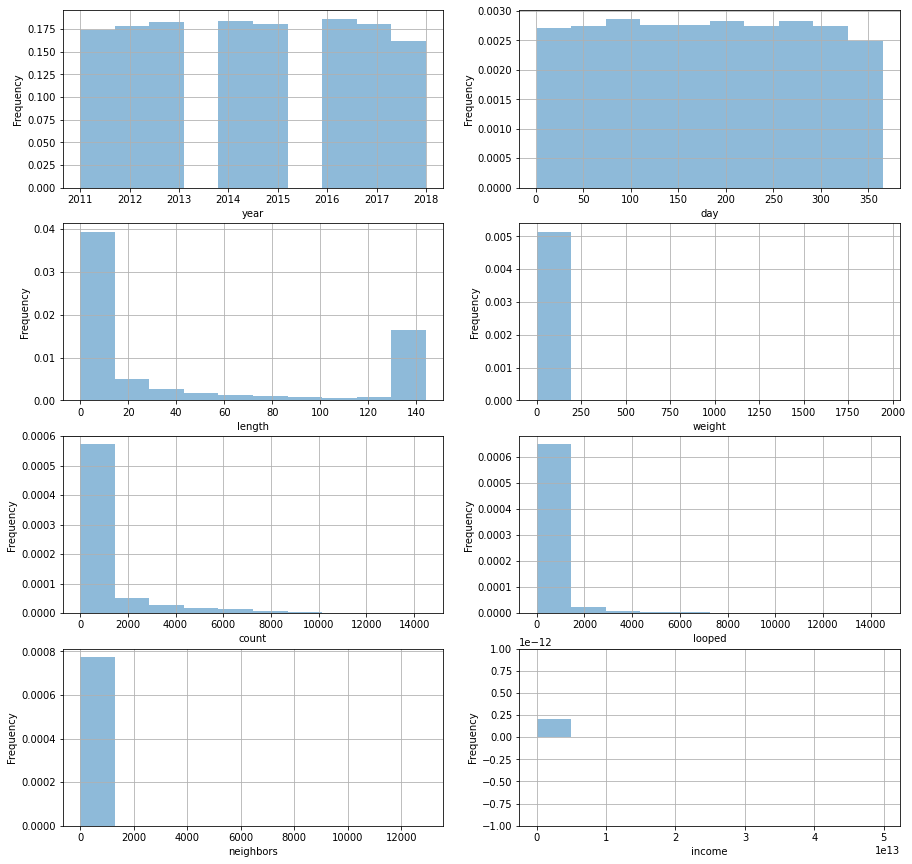

In [ ]:
plt.figure(figsize=(15,15))

plt.subplot(4,2,1)
df['year'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('year')

plt.subplot(4,2,2)
df['day'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('day')

plt.subplot(4,2,3)
df['length'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('length')

plt.subplot(4,2,4)
df['weight'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('weight')

plt.subplot(4,2,5)
df['count'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('count')

plt.subplot(4,2,6)
df['looped'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('looped')

plt.subplot(4,2,7)
df['neighbors'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('neighbors')

plt.subplot(4,2,8)
df['income'].plot.hist(alpha=0.5, bins=10, density=1, grid = True)
plt.xlabel('income')

plt.show()

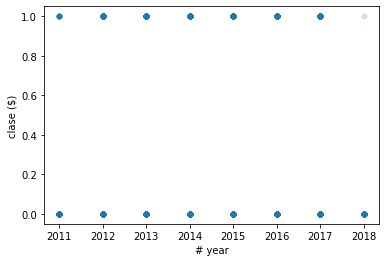

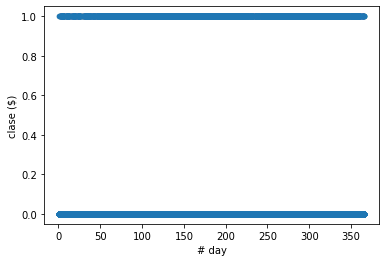

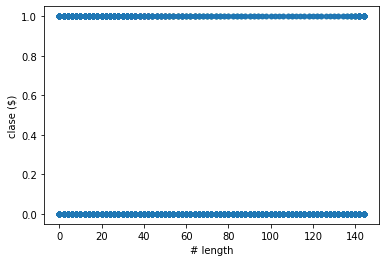

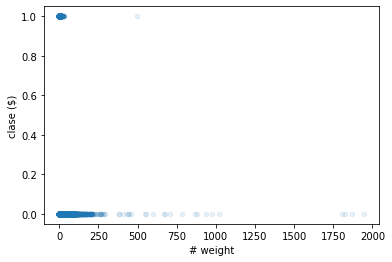

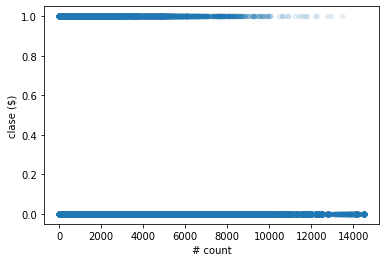

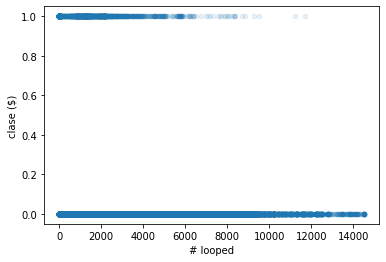

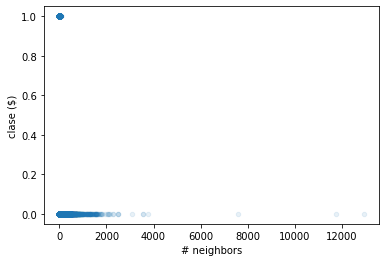

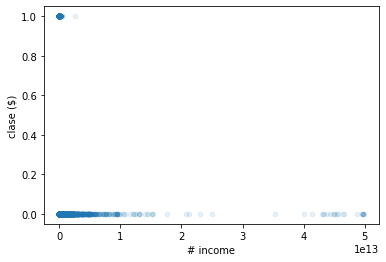

In [ ]:
# La utilización de transparencia (alpha) puede ser útil para apreciar la densidad de los datos

df.plot(kind = 'scatter', x='year', y = 'clase', alpha=0.1)
plt.xlabel('# year')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='day', y = 'clase', alpha=0.1)
plt.xlabel('# day')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='length', y = 'clase', alpha=0.1)
plt.xlabel('# length')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='weight', y = 'clase', alpha=0.1)
plt.xlabel('# weight')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='count', y = 'clase', alpha=0.1)
plt.xlabel('# count')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='looped', y = 'clase', alpha=0.1)
plt.xlabel('# looped')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='neighbors', y = 'clase', alpha=0.1)
plt.xlabel('# neighbors')
plt.ylabel('clase ($)')
plt.show()

df.plot(kind = 'scatter', x='income', y = 'clase', alpha=0.1)
plt.xlabel('# income')
plt.ylabel('clase ($)')
plt.show()

In [ ]:
df.corr() # matriz de correlación

,year,day,length,weight,count,looped,neighbors,income,clase
year,1.000000,-0.040324,0.162864,0.011500,0.285282,0.113296,-0.000595,-0.020559,0.021277
day,-0.040324,1.000000,0.011558,0.000972,-0.002808,0.002331,0.000308,0.002630,-0.007968
length,0.162864,0.011558,1.000000,0.000343,0.703436,0.411440,0.030189,0.000704,-0.006683
weight,0.011500,0.000972,0.000343,1.000000,0.021294,0.058901,0.698533,0.072214,0.002547
count,0.285282,-0.002808,0.703436,0.021294,1.000000,0.560534,0.024385,-0.003486,-0.008473
looped,0.113296,0.002331,0.411440,0.058901,0.560534,1.000000,0.050787,0.002736,-0.017755
neighbors,-0.000595,0.000308,0.030189,0.698533,0.024385,0.050787,1.000000,0.142581,-0.000923
income,-0.020559,0.002630,0.000704,0.072214,-0.003486,0.002736,0.142581,1.000000,-0.002690
clase,0.021277,-0.007968,-0.006683,0.002547,-0.008473,-0.017755,-0.000923,-0.002690,1.000000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


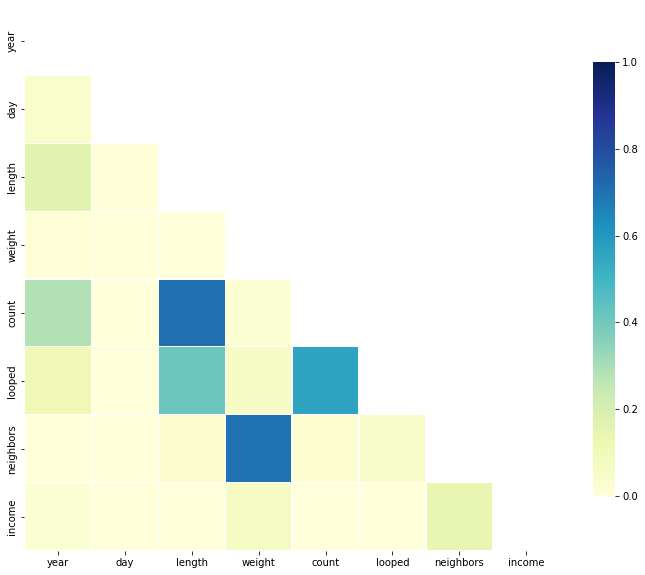

In [ ]:
# Compute the correlation matrix
corr = np.abs(df.drop(['clase'], axis=1).corr())

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmin = 0.0, vmax=1.0, center=0.5,
            linewidths=.1, cmap="YlGnBu", cbar_kws={"shrink": .8})

plt.show()

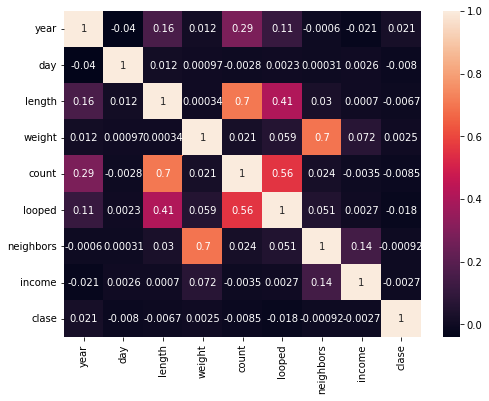

In [ ]:
corr_df = df.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True)
plt.show()

In [ ]:
corr_df.style.background_gradient(cmap='coolwarm')

,year,day,length,weight,count,looped,neighbors,income,clase
year,1.000000,-0.040324,0.162864,0.011500,0.285282,0.113296,-0.000595,-0.020559,0.021277
day,-0.040324,1.000000,0.011558,0.000972,-0.002808,0.002331,0.000308,0.002630,-0.007968
length,0.162864,0.011558,1.000000,0.000343,0.703436,0.411440,0.030189,0.000704,-0.006683
weight,0.011500,0.000972,0.000343,1.000000,0.021294,0.058901,0.698533,0.072214,0.002547
count,0.285282,-0.002808,0.703436,0.021294,1.000000,0.560534,0.024385,-0.003486,-0.008473
looped,0.113296,0.002331,0.411440,0.058901,0.560534,1.000000,0.050787,0.002736,-0.017755
neighbors,-0.000595,0.000308,0.030189,0.698533,0.024385,0.050787,1.000000,0.142581,-0.000923
income,-0.020559,0.002630,0.000704,0.072214,-0.003486,0.002736,0.142581,1.000000,-0.002690
clase,0.021277,-0.007968,-0.006683,0.002547,-0.008473,-0.017755,-0.000923,-0.002690,1.000000


### Selección de características: métodos de filtrado

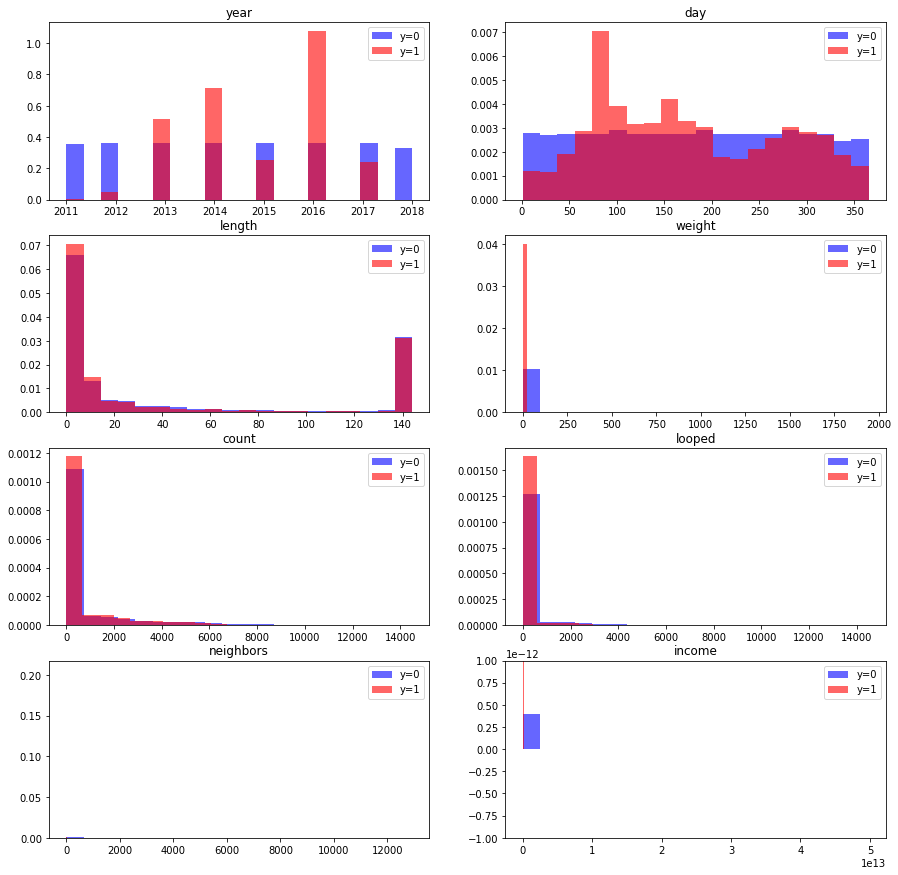

In [ ]:
# Histograma de cada variable separado por clases
plt.figure(figsize=(15,15))

idx_0 =  df['clase'] == 0
idx_1 =  df['clase'] == 1

for i, feature in enumerate(df.columns.drop(['clase'])):
    plt.subplot(4, 2, i+1)   
    plt.hist(df.loc[idx_0,feature],density=1, bins=20, facecolor=(0,0,1,0.6), label='y=0')
    plt.hist(df.loc[idx_1,feature],density=1, bins=20, facecolor=(1,0,0,0.6), label='y=1')
    plt.legend()
    plt.title(feature)
plt.show()

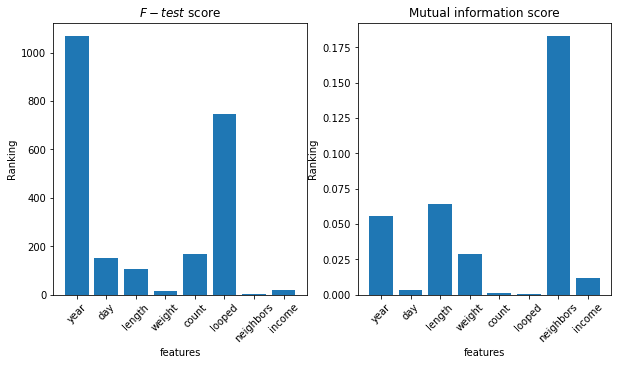

In [ ]:
data = df.to_numpy()
y = data[:, 8]     # nos quedamos con la última columna, binary_label
X = data[:,:8]      # nos quedamos con el resto

featureNames = df.columns.values[:8]

# do calculations
f_test, _ = f_classif(X, y)
#f_test /= np.max(f_test)

mi = mutual_info_classif(X, y)
#mi /= np.max(mi)

# do some plotting
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.bar(range(X.shape[1]), f_test,  align="center")
plt.xticks(range(X.shape[1]), featureNames, rotation=45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('$F-test$ score')


plt.subplot(1,2,2)
plt.bar(range(X.shape[1]),mi,  align="center")
plt.xticks(range(X.shape[1]),featureNames, rotation=45)
plt.xlabel('features')
plt.ylabel('Ranking')
plt.title('Mutual information score')

plt.show()

### Selección de características: métodos embedded

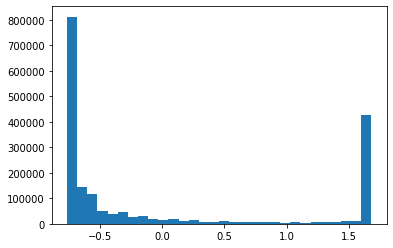

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = seed)

# Escalamos (obtenemos la transformación con los datos de train y la aplicamos a train y a test)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

plt.hist(X_train_scaled[:,2], bins=30)
plt.show()

best mean cross-validation score: -0.014
best parameters: {'alpha': 4.520353656360241e-06}


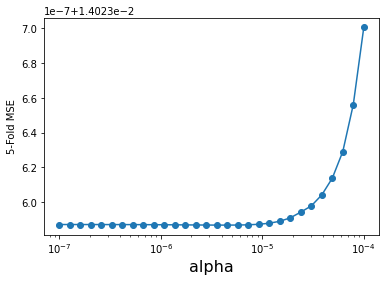

In [ ]:
K = 5 # número de folds

# Rango de búsqueda del parámetro de regularización (mejor en escala logarítmica)
# primera iteración
# alpha_vector = np.logspace(-7, 10, 50)
# segunda iteración (zoom)
# alpha_vector = np.logspace(-7, -2, 20)
# tercera iteración (zoom)
alpha_vector = np.logspace(-7, -4, 30)

param_grid = {'alpha': alpha_vector}
grid = GridSearchCV(Lasso(), scoring= 'neg_mean_squared_error', param_grid=param_grid, cv = K)
grid.fit(X_train_scaled, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = -1*np.array(grid.cv_results_['mean_test_score'])
plt.semilogx(alpha_vector, scores,'-o')
plt.xlabel('alpha', fontsize=16)
plt.ylabel('{}-Fold MSE'.format(K))
#plt.ylim((-1, 0))
plt.show()

In [ ]:
alpha_optimo = grid.best_params_['alpha']

lasso = Lasso(alpha = alpha_optimo).fit(X_train_scaled, y_train)

ytrainLasso = lasso.predict(X_train_scaled)
ytestLasso  = lasso.predict(X_test_scaled)
mseTrainModelLasso = mean_squared_error(y_train, ytrainLasso)
mseTestModelLasso = mean_squared_error(y_test, ytestLasso)

print('alpha: %0.3g' % alpha_optimo)

print('MSE Modelo Lasso (train): %0.3g' % mseTrainModelLasso)
print('MSE Modelo Lasso (test) : %0.3g' % mseTestModelLasso)

print('RMSE Modelo Lasso (train): %0.3g' % np.sqrt(mseTrainModelLasso))
print('RMSE Modelo Lasso (test) : %0.3g' % np.sqrt(mseTestModelLasso))

w = lasso.coef_
for f, wi in zip(featureNames, w):
    print("{}: {}".format(f, wi))

alpha: 4.52e-06
MSE Modelo Lasso (train): 0.014
MSE Modelo Lasso (test) : 0.0138
RMSE Modelo Lasso (train): 0.118
RMSE Modelo Lasso (test) : 0.118
year: 0.002947121391430012
day: -0.0008356818659241389
length: 0.0001446621872715825
weight: 0.0007508159153221959
count: -0.0008515920369221731
looped: -0.002045335630045483
neighbors: -0.00048301289091627706
income: -0.00024255641935500008


Finalmente se decide eliminar las variables length y weight